In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

In [2]:
myData = pd.read_csv('/Users/richlegendary/Desktop/GSB-S544/data/Hitters.csv')

In [3]:
# Clean my data a bit

# Get rid of columns with mostly NaN values
good_cols = myData.isna().sum() < 100
myData = myData.loc[:,good_cols]

# Drop other NAs
myData = myData.dropna()

In [4]:
myData

AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  \
1      315    81      7    24   38     39     14    3449    835      69   
2      479   130     18    66   72     76      3    1624    457      63   
3      496   141     20    65   78     37     11    5628   1575     225   
4      321    87     10    39   42     30      2     396    101      12   
5      594   169      4    74   51     35     11    4408   1133      19   
..     ...   ...    ...   ...  ...    ...    ...     ...    ...     ...   
317    497   127      7    65   48     37      5    2703    806      32   
318    492   136      5    76   50     94     12    5511   1511      39   
319    475   126      3    61   43     52      6    1700    433       7   
320    573   144      9    85   60     78      8    3198    857      97   
321    631   170      9    77   44     31     11    4908   1457      30   

     CRuns  CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary  \
1      321   414     375      N        W      632       43      10   475.0   
2      224   266     263      A        W      880       82      14   480.0   
3      828   838     354      N        E      200       11       3   500.0   
4       48    46      33      N        E      805       40       4    91.5   
5      501   336     194      A        W      282      421      25   750.0   
..     ...   ...     ...    ...      ...      ...      ...     ...     ...   
317    379   311     138      N        E      325        9       3   700.0   
318    897   451     875      A        E      313      381      20   875.0   
319    217    93     146      A        W       37      113       7   385.0   
320    470   420     332      A        E     1314      131      12   960.0   
321    775   357     249      A        W      408        4       3  1000.0   

    NewLeague  
1           N  
2           A  
3           N  
4           N  
5           A  
..        ...  
317         N  
318         A  
319         A  
320         A  
321         A  

[263 rows x 20 columns]

Part I: Different Model Specs

A. Regression without regularization

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression



In [5]:
X = myData.drop(["Salary"], axis = 1)
y = myData["Salary"]


ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

2. Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

In [6]:
lr_fitted = lr_pipeline_1.fit(X, y)
ln_cof = lr_fitted.named_steps ['linear_regression'].coef_
ln_cof

array([ -31.29971152,   31.29971152,   58.42462282,  -58.42462282,
         12.38116255,  -12.38116255, -291.0945557 ,  337.83047948,
         37.85383676,  -60.57247861,  -26.99498379,  135.07389695,
        -16.69335888, -391.03865466,   86.68761664,  -14.18172332,
        480.74713477,  260.68988581, -213.89225864,   78.76129639,
         53.73248973,  -22.16086217])

In [7]:
preprocessed_columns = lr_pipeline_1.named_steps['preprocessing'].get_feature_names_out()

coefficients_with_names = list(zip(preprocessed_columns, ln_cof))

ln_data = {'Coefficient': [], 'Var_name': []}

for coef, var_name in coefficients_with_names:
    ln_data['Var_name'].append(coef)
    ln_data['Coefficient'].append(var_name)

linear_coefficients_df = pd.DataFrame(ln_data)
print(linear_coefficients_df)

    Coefficient              Var_name
0    -31.299712     dummify__League_A
1     31.299712     dummify__League_N
2     58.424623   dummify__Division_E
3    -58.424623   dummify__Division_W
4     12.381163  dummify__NewLeague_A
5    -12.381163  dummify__NewLeague_N
6   -291.094556    standardize__AtBat
7    337.830479     standardize__Hits
8     37.853837    standardize__HmRun
9    -60.572479     standardize__Runs
10   -26.994984      standardize__RBI
11   135.073897    standardize__Walks
12   -16.693359    standardize__Years
13  -391.038655   standardize__CAtBat
14    86.687617    standardize__CHits
15   -14.181723   standardize__CHmRun
16   480.747135    standardize__CRuns
17   260.689886     standardize__CRBI
18  -213.892259   standardize__CWalks
19    78.761296  standardize__PutOuts
20    53.732490  standardize__Assists
21   -22.160862   standardize__Errors


Since we standardized the numeric and dummified the categorical, the bigger the values the attribute has, it means its more taking a bigger weight in measuring salary. Some of the biggest number we see here is CRuns with 481, Hits with 338, and CAtBat with -391. 
With each standard deviation the player has above the mean of number of runs in his carrer, his salary will go up by 481,000.
With each standard deviation the player has above the mean of number of hits in 1986, his salary will go up by 338,000.
With each standard deviation the player has above the mean of number of times at bat in his career, his salary will go down by 391,000.

3. Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [8]:
mse_scores_negative = cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = 'neg_mean_squared_error')
mse_scores_positive = -mse_scores_negative
mse = np.mean(mse_scores_positive)
mse

121556.06500734284

B. Ridge regression

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

In [9]:
ridge_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(1))]
)

2. Use cross-validation to tune the hyperparameter.

In [10]:
ridge_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge())]
)

degrees = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv = GridSearchCV(ridge_pipeline_1, degrees, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X, y)

gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10], "scores": gscv_fitted.cv_results_['mean_test_score']})

ridge_regression__alpha    scores
0                    0.001  0.343556
1                    0.010  0.344084
2                    0.100  0.347675
3                    1.000  0.355767
4                   10.000  0.368328

The highest R2 we get it's from alpha =100. 

3. Fit the pipeline with your chosen to the full dataset, and interpret a few of the most important coefficients.

In [47]:
ridge_pipeline_tuned = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(10))]
)
ridge_tuned_fitted = ridge_pipeline_tuned.fit(X, y)
ridge_tuned_cof = ridge_tuned_fitted.named_steps ['ridge_regression'].coef_
ridge_tuned_cof

array([ -24.41466972,   24.41466972,   59.71825178,  -59.71825178,
          7.58713137,   -7.58713137, -133.99591514,  152.62659818,
        -10.22097213,   21.67855787,   16.28771149,   82.57729094,
        -48.46625667,  -20.19003285,   97.38437356,   58.33691532,
        119.70171225,   92.47134762,  -93.93214054,   75.3076013 ,
         28.96674963,  -24.91906195])

In [13]:
preprocessed_columns_ridge = ridge_pipeline_tuned.named_steps['preprocessing'].get_feature_names_out()

coefficients_with_names = list(zip(preprocessed_columns_ridge, ridge_tuned_cof))

ridge_data = {'Coefficient': [], 'Var_name': []}

for coef, var_name in coefficients_with_names:
    ridge_data['Var_name'].append(coef)
    ridge_data['Coefficient'].append(var_name)

ridge_coefficients_df = pd.DataFrame(ridge_data)
print(ridge_coefficients_df)

    Coefficient              Var_name
0    -24.414670     dummify__League_A
1     24.414670     dummify__League_N
2     59.718252   dummify__Division_E
3    -59.718252   dummify__Division_W
4      7.587131  dummify__NewLeague_A
5     -7.587131  dummify__NewLeague_N
6   -133.995915    standardize__AtBat
7    152.626598     standardize__Hits
8    -10.220972    standardize__HmRun
9     21.678558     standardize__Runs
10    16.287711      standardize__RBI
11    82.577291    standardize__Walks
12   -48.466257    standardize__Years
13   -20.190033   standardize__CAtBat
14    97.384374    standardize__CHits
15    58.336915   standardize__CHmRun
16   119.701712    standardize__CRuns
17    92.471348     standardize__CRBI
18   -93.932141   standardize__CWalks
19    75.307601  standardize__PutOuts
20    28.966750  standardize__Assists
21   -24.919062   standardize__Errors


Since we standardized the numeric and dummified the categorical, the bigger the values the attribute has, it means its more taking a bigger weight in measuring salary. Some of the biggest number we see here is CRuns with 120, Hits with 153, and AtBat with -134. 
With each standard deviation the player has above the mean of number of runs in his carrer, his salary will go up by 120,000.
With each standard deviation the player has above the mean of number of hits in 1986, his salary will go up by 153,000.
With each standard deviation the player has above the mean of number of times at bat in 1986, his salary will go down by 134,000.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.



In [14]:
mse_scores_negative = cross_val_score(ridge_pipeline_tuned, X, y, cv = 5, scoring = 'neg_mean_squared_error')
mse_scores_positive = -mse_scores_negative
mse = np.mean(mse_scores_positive)
mse

119348.98477570359

C. Lasso Regression

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary lasso regression

In [15]:
lasso_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso())]
)

2. Use cross-validation to tune the hyperparameter.

In [16]:
lasso_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso())]
)

degrees = {'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv = GridSearchCV(lasso_pipeline_1, degrees, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X, y)

gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10], "scores": gscv_fitted.cv_results_['mean_test_score']})

/Users/richlegendary/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.004e+07, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/Users/richlegendary/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.984e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/Users/richlegendary/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

lasso_regression__alpha    scores
0                    0.001  0.344223
1                    0.010  0.344394
2                    0.100  0.346041
3                    1.000  0.354238
4                   10.000  0.369523

The highest R2 we get it's from alpha =10. 

3. Fit the pipeline with your chosen to the full dataset, and interpret a few of the most important coefficients.



In [17]:
lasso_pipeline_tuned = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso(10))]
)
lasso_tuned_fitted = lasso_pipeline_tuned.fit(X, y)
lasso_tuned_cof = lasso_tuned_fitted.named_steps ['lasso_regression'].coef_
lasso_tuned_cof

array([-0.00000000e+00,  0.00000000e+00,  9.54132032e+01, -3.32794771e-12,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  8.87416269e+01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.99028129e+01,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        7.22275293e+01,  1.34032027e+02, -0.00000000e+00,  6.67370055e+01,
        0.00000000e+00, -4.15828061e+00])

In [18]:
preprocessed_columns_lasso = lasso_pipeline_tuned.named_steps['preprocessing'].get_feature_names_out()

coefficients_with_names = list(zip(preprocessed_columns_lasso, lasso_tuned_cof))

lasso_data = {'Coefficient': [], 'Var_name': []}

for coef, var_name in coefficients_with_names:
    lasso_data['Var_name'].append(coef)
    lasso_data['Coefficient'].append(var_name)

lasso_coefficients_df = pd.DataFrame(lasso_data)
print(lasso_coefficients_df)

     Coefficient              Var_name
0  -0.000000e+00     dummify__League_A
1   0.000000e+00     dummify__League_N
2   9.541320e+01   dummify__Division_E
3  -3.327948e-12   dummify__Division_W
4  -0.000000e+00  dummify__NewLeague_A
5   0.000000e+00  dummify__NewLeague_N
6  -0.000000e+00    standardize__AtBat
7   8.874163e+01     standardize__Hits
8   0.000000e+00    standardize__HmRun
9   0.000000e+00     standardize__Runs
10  0.000000e+00      standardize__RBI
11  4.990281e+01    standardize__Walks
12 -0.000000e+00    standardize__Years
13  0.000000e+00   standardize__CAtBat
14  0.000000e+00    standardize__CHits
15  0.000000e+00   standardize__CHmRun
16  7.222753e+01    standardize__CRuns
17  1.340320e+02     standardize__CRBI
18 -0.000000e+00   standardize__CWalks
19  6.673701e+01  standardize__PutOuts
20  0.000000e+00  standardize__Assists
21 -4.158281e+00   standardize__Errors


Since we standardized the numeric and dummified the categorical, the bigger the values the attribute has, it means its more taking a bigger weight in measuring salary. Some of the biggest number we see here is CRuns with 72, Hits with 88, and CRBI with 134. 
With each standard deviation the player has above the mean of number of runs in his carrer, his salary will go up by 72,000.
With each standard deviation the player has above the mean of number of hits in 1986, his salary will go up by 88,000.
With each standard deviation the player has above the mean of number of runs batted in his career, his salary will go up by 134,000.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.



In [19]:
mse_scores_negative = cross_val_score(lasso_pipeline_tuned, X, y, cv = 5, scoring = 'neg_mean_squared_error')
mse_scores_positive = -mse_scores_negative
mse = np.mean(mse_scores_positive)
mse

121828.14133338635

D. Elastic Net

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression



In [20]:
elastic_net_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("elastic_net", ElasticNet(alpha=(),l1_ratio=()))]
)

2. Use cross-validation to tune the hyperparameter.

In [21]:
elastic_net_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("elastic_net", ElasticNet())]
)

degrees = {
    'elastic_net__alpha': [0.001, 0.01, 0.1, 1,10],
    'elastic_net__l1_ratio': [0.0001, 0.001, 0.01, 0.1, 1]  
}

gscv = GridSearchCV(elastic_net_pipeline_1, degrees, cv = 5, scoring='r2')
gscv_fitted = gscv.fit(X, y)

gscv_fitted.cv_results_['mean_test_score']

tuned_df = pd.DataFrame({
    'alpha': gscv_fitted.cv_results_['param_elastic_net__alpha'],
    'l1_ratio': gscv_fitted.cv_results_['param_elastic_net__l1_ratio'],
    'mean_test_score': gscv_fitted.cv_results_['mean_test_score']
})

tuned_df


/Users/richlegendary/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.045e+07, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/Users/richlegendary/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.229e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/Users/richlegendary/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

/Users/richlegendary/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.004e+06, tolerance: 4.137e+03
  model = cd_fast.enet_coordinate_descent(
/Users/richlegendary/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.704e+06, tolerance: 4.281e+03
  model = cd_fast.enet_coordinate_descent(
/Users/richlegendary/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

alpha l1_ratio  mean_test_score
0   0.001   0.0001         0.350093
1   0.001    0.001         0.350090
2   0.001     0.01         0.350060
3   0.001      0.1         0.349742
4   0.001        1         0.344223
5    0.01   0.0001         0.359198
6    0.01    0.001         0.359193
7    0.01     0.01         0.359147
8    0.01      0.1         0.358668
9    0.01        1         0.344394
10    0.1   0.0001         0.373287
11    0.1    0.001         0.373281
12    0.1     0.01         0.373217
13    0.1      0.1         0.372547
14    0.1        1         0.346041
15      1   0.0001         0.386199
16      1    0.001         0.386202
17      1     0.01         0.386237
18      1      0.1         0.386511
19      1        1         0.354238
20     10   0.0001         0.255653
21     10    0.001         0.255756
22     10     0.01         0.256788
23     10      0.1         0.267491
24     10        1         0.369523

In [22]:
max_index = tuned_df['mean_test_score'].idxmax()

row_with_max_value = tuned_df.loc[max_index]

print(row_with_max_value)

alpha                     1
l1_ratio                0.1
mean_test_score    0.386511
Name: 18, dtype: object


The highest R2 we get is from alpha=1, l1_ratio=0.1. 

3. Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.

In [23]:
elastic_net_pipeline_tuned = Pipeline(
  [("preprocessing", ct),
  ("elastic_net", ElasticNet(alpha=1, l1_ratio=0.1))]
)


elastic_net_tuned_fitted = elastic_net_pipeline_tuned.fit(X, y)
elastic_net_tuned_cof = elastic_net_tuned_fitted.named_steps ['elastic_net'].coef_
elastic_net_tuned_cof

array([ -6.77547795,   6.775496  ,  24.40355918, -24.40354997,
        -4.04830014,   4.0483143 ,  13.3396458 ,  35.94158547,
         6.60351486,  26.57294804,  22.91221172,  33.56503997,
         8.7975977 ,  25.81105282,  35.03611085,  31.46111891,
        35.83960043,  36.67326041,  16.39412975,  42.82968834,
         3.56879348,  -7.41602107])

In [24]:
preprocessed_columns_elastic_net = elastic_net_pipeline_tuned.named_steps['preprocessing'].get_feature_names_out()

coefficients_with_names = list(zip(preprocessed_columns_elastic_net, elastic_net_tuned_cof))

elastic_net_data = {'Var_name': [], 'Coefficient': []}

for coef, var_name in coefficients_with_names:
    elastic_net_data['Var_name'].append(coef)
    elastic_net_data['Coefficient'].append(var_name)

elastic_net_coefficients_df = pd.DataFrame(elastic_net_data)
print(elastic_net_coefficients_df)

                Var_name  Coefficient
0      dummify__League_A    -6.775478
1      dummify__League_N     6.775496
2    dummify__Division_E    24.403559
3    dummify__Division_W   -24.403550
4   dummify__NewLeague_A    -4.048300
5   dummify__NewLeague_N     4.048314
6     standardize__AtBat    13.339646
7      standardize__Hits    35.941585
8     standardize__HmRun     6.603515
9      standardize__Runs    26.572948
10      standardize__RBI    22.912212
11    standardize__Walks    33.565040
12    standardize__Years     8.797598
13   standardize__CAtBat    25.811053
14    standardize__CHits    35.036111
15   standardize__CHmRun    31.461119
16    standardize__CRuns    35.839600
17     standardize__CRBI    36.673260
18   standardize__CWalks    16.394130
19  standardize__PutOuts    42.829688
20  standardize__Assists     3.568793
21   standardize__Errors    -7.416021


Since we standardized the numeric and dummified the categorical, the bigger the values the attribute has, it means its more taking a bigger weight in measuring salary. Some of the biggest number we see here is CRuns with 35, Hits with 35, and CRBI with 36. 
With each standard deviation the player has above the mean of number of runs in his carrer, his salary will go up by 35,000.
With each standard deviation the player has above the mean of number of hits in 1986, his salary will go up by 35,000.
With each standard deviation the player has above the mean of number of runs batted in his career, his salary will go up by 36,000.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [25]:
mse_scores_negative = cross_val_score(elastic_net_pipeline_tuned, X, y, cv = 5, scoring = 'neg_mean_squared_error')
mse_scores_positive = -mse_scores_negative
mse = np.mean(mse_scores_positive)
mse

121760.92284051597

Part II. Variable Selection

Based on the above results, decide on:

Which numeric variable is most important.

Which five numeric variables are most important

Which categorical variable is most important

Since everything is standardized, the bigger the coefficent is, the more impact it has on salary. I will list all the coefficient descending by each model, give them a variable call rank. Find the average number of rank of variables, the smallest one is the most important one. 

In [26]:
linear_coefficients_df['Absolute_Coef']=abs(linear_coefficients_df['Coefficient'])
linear_cofficients_df = linear_coefficients_df.sort_values(by='Absolute_Coef', ascending = False, inplace = True)
linear_coefficients_df['importance_ln'] = range(1, len(linear_coefficients_df) + 1)
print(linear_coefficients_df)

    Coefficient              Var_name  Absolute_Coef  importance_ln
16   480.747135    standardize__CRuns     480.747135              1
13  -391.038655   standardize__CAtBat     391.038655              2
7    337.830479     standardize__Hits     337.830479              3
6   -291.094556    standardize__AtBat     291.094556              4
17   260.689886     standardize__CRBI     260.689886              5
18  -213.892259   standardize__CWalks     213.892259              6
11   135.073897    standardize__Walks     135.073897              7
14    86.687617    standardize__CHits      86.687617              8
19    78.761296  standardize__PutOuts      78.761296              9
9    -60.572479     standardize__Runs      60.572479             10
3    -58.424623   dummify__Division_W      58.424623             11
2     58.424623   dummify__Division_E      58.424623             12
20    53.732490  standardize__Assists      53.732490             13
8     37.853837    standardize__HmRun      37.85

In [27]:
ridge_coefficients_df['Absolute_Coef'] = abs(ridge_coefficients_df['Coefficient'])
ridge_coefficients_df.sort_values(by='Absolute_Coef', ascending=False, inplace=True)
ridge_coefficients_df.reset_index(drop=True, inplace=True)
ridge_coefficients_df['importance_ridge'] = range(1, len(ridge_coefficients_df) + 1)
print(ridge_coefficients_df)


    Coefficient              Var_name  Absolute_Coef  importance_ridge
0    152.626598     standardize__Hits     152.626598                 1
1   -133.995915    standardize__AtBat     133.995915                 2
2    119.701712    standardize__CRuns     119.701712                 3
3     97.384374    standardize__CHits      97.384374                 4
4    -93.932141   standardize__CWalks      93.932141                 5
5     92.471348     standardize__CRBI      92.471348                 6
6     82.577291    standardize__Walks      82.577291                 7
7     75.307601  standardize__PutOuts      75.307601                 8
8    -59.718252   dummify__Division_W      59.718252                 9
9     59.718252   dummify__Division_E      59.718252                10
10    58.336915   standardize__CHmRun      58.336915                11
11   -48.466257    standardize__Years      48.466257                12
12    28.966750  standardize__Assists      28.966750                13
13   -

In [28]:
lasso_coefficients_df['Absolute_Coef'] = abs(lasso_coefficients_df['Coefficient'])
lasso_coefficients_df.sort_values(by='Absolute_Coef', ascending=False, inplace=True)
lasso_coefficients_df.reset_index(drop=True, inplace=True)
lasso_coefficients_df['importance_lasso'] = range(1, len(lasso_coefficients_df) + 1)
print(lasso_coefficients_df)

     Coefficient              Var_name  Absolute_Coef  importance_lasso
0   1.340320e+02     standardize__CRBI   1.340320e+02                 1
1   9.541320e+01   dummify__Division_E   9.541320e+01                 2
2   8.874163e+01     standardize__Hits   8.874163e+01                 3
3   7.222753e+01    standardize__CRuns   7.222753e+01                 4
4   6.673701e+01  standardize__PutOuts   6.673701e+01                 5
5   4.990281e+01    standardize__Walks   4.990281e+01                 6
6  -4.158281e+00   standardize__Errors   4.158281e+00                 7
7  -3.327948e-12   dummify__Division_W   3.327948e-12                 8
8  -0.000000e+00    standardize__AtBat   0.000000e+00                 9
9   0.000000e+00    standardize__HmRun   0.000000e+00                10
10  0.000000e+00     standardize__Runs   0.000000e+00                11
11  0.000000e+00      standardize__RBI   0.000000e+00                12
12  0.000000e+00     dummify__League_N   0.000000e+00           

In [29]:
elastic_net_coefficients_df['Absolute_Coef'] = abs(elastic_net_coefficients_df['Coefficient'])
elastic_net_coefficients_df.sort_values(by='Absolute_Coef', ascending=False, inplace=True)
elastic_net_coefficients_df.reset_index(drop=True, inplace=True)
elastic_net_coefficients_df['importance_elastic_net'] = range(1, len(elastic_net_coefficients_df) + 1)

print(elastic_net_coefficients_df)

                Var_name  Coefficient  Absolute_Coef  importance_elastic_net
0   standardize__PutOuts    42.829688      42.829688                       1
1      standardize__CRBI    36.673260      36.673260                       2
2      standardize__Hits    35.941585      35.941585                       3
3     standardize__CRuns    35.839600      35.839600                       4
4     standardize__CHits    35.036111      35.036111                       5
5     standardize__Walks    33.565040      33.565040                       6
6    standardize__CHmRun    31.461119      31.461119                       7
7      standardize__Runs    26.572948      26.572948                       8
8    standardize__CAtBat    25.811053      25.811053                       9
9    dummify__Division_E    24.403559      24.403559                      10
10   dummify__Division_W   -24.403550      24.403550                      11
11      standardize__RBI    22.912212      22.912212                      12

In [30]:
merged_df = pd.merge(ridge_coefficients_df[['Var_name', 'importance_ridge']],
                     lasso_coefficients_df[['Var_name', 'importance_lasso']],
                     on='Var_name', how='outer')
merged_df = pd.merge(merged_df,
                     elastic_net_coefficients_df[['Var_name', 'importance_elastic_net']],
                     on='Var_name', how='outer')
merged_df = pd.merge(merged_df,
                     linear_coefficients_df[['Var_name', 'importance_ln']],
                     on='Var_name', how='outer')

importance_columns = ['importance_ln','importance_ridge', 'importance_lasso', 'importance_elastic_net']
merged_df['average_importance'] = merged_df[importance_columns].mean(axis=1)

merged_df.sort_values(by='average_importance', ascending=True, inplace=True)
merged_df.reset_index(drop=True, inplace=True)

print(merged_df)


                Var_name  importance_ridge  importance_lasso  \
0      standardize__Hits                 1                 3   
1     standardize__CRuns                 3                 4   
2      standardize__CRBI                 6                 1   
3   standardize__PutOuts                 8                 5   
4     standardize__Walks                 7                 6   
5     standardize__AtBat                 2                 9   
6     standardize__CHits                 4                16   
7    dummify__Division_E                10                 2   
8    dummify__Division_W                 9                 8   
9    standardize__CWalks                 5                20   
10   standardize__CAtBat                18                15   
11     standardize__Runs                17                11   
12   standardize__Errors                14                 7   
13   standardize__CHmRun                11                17   
14     dummify__League_N                

Based on this results,

The most important numeric variable is Hits

The five most important numeric vars are Hits, CRuns, CRBI, Putouts, Walks.

The most important categorical var is Division.


For each of the four model specifications, compare the following possible feature sets:

Using only the one best numeric variable.

Using only the five best variables.

Using the five best numeric variables and their interactions with the one best categorical variable.

Report which combination of features and model performed best, based on the validation metric of MSE.

(Note: 
 and 
 must be re-tuned for each feature set.)

In [43]:
#Using the most important numeric
X_1 = myData[['Hits']]
y_1 = myData["Salary"]

linear with hits

In [41]:
lr_pipeline_2 = Pipeline(
  [
  ("linear_regression", LinearRegression())]
)

In [45]:
mse_scores_negative = cross_val_score(lr_pipeline_2, X_1, y_1, cv = 5, scoring = 'neg_mean_squared_error')
mse_scores_positive = -mse_scores_negative
mse_hits_1 = np.mean(mse_scores_positive)
mse_hits_1

173088.9728644403

ridge with hits

In [48]:
ridge_pipeline_2 = Pipeline(
  [
  ("ridge_regression", Ridge())]
)

degrees = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv = GridSearchCV(ridge_pipeline_2, degrees, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X_1, y_1)

gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10], "scores": gscv_fitted.cv_results_['mean_test_score']})

ridge_regression__alpha    scores
0                    0.001  0.122213
1                    0.010  0.122213
2                    0.100  0.122213
3                    1.000  0.122213
4                   10.000  0.122215

alpha = 10 gives the highest r2.

In [52]:
ridge_pipeline_tuned = Pipeline(
  [
  ("ridge_regression", Ridge(10))]
)
ridge_tuned_fitted = ridge_pipeline_tuned.fit(X_1, y_1)
ridge_tuned_cof = ridge_tuned_fitted.named_steps ['ridge_regression'].coef_
ridge_tuned_cof


mse_scores_negative = cross_val_score(ridge_pipeline_tuned, X_1, y_1, cv = 5, scoring = 'neg_mean_squared_error')
mse_scores_positive = -mse_scores_negative
mse_hits_ridge = np.mean(mse_scores_positive)
mse_hits_ridge

173088.7284555155

lasso with hits

In [58]:
lasso_pipeline_2 = Pipeline([
    ("lasso_regression", Lasso())
])

degrees = {'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10] }
gscv_lasso = GridSearchCV(lasso_pipeline_2, degrees, cv=5, scoring='r2')
gscv_lasso_fitted = gscv_lasso.fit(X_1, y_1)

mean_test_scores_lasso = gscv_lasso_fitted.cv_results_['mean_test_score']

results_df_lasso = pd.DataFrame(data={'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10] , "scores": mean_test_scores_lasso})
results_df_lasso

lasso_regression__alpha    scores
0                    0.001  0.122213
1                    0.010  0.122213
2                    0.100  0.122213
3                    1.000  0.122219
4                   10.000  0.122278

alpha = 10 gives the highest r2

In [59]:
lasso_pipeline_tuned = Pipeline(
  [
  ("lasso_regression", Lasso(10))]
)
lasso_tuned_fitted = lasso_pipeline_tuned.fit(X_1, y_1)
lasso_tuned_cof = lasso_tuned_fitted.named_steps['lasso_regression'].coef_
lasso_tuned_cof


mse_scores_negative_lasso = cross_val_score(lasso_pipeline_tuned, X_1, y_1, cv=5, scoring='neg_mean_squared_error')
mse_scores_positive_lasso = -mse_scores_negative_lasso
mse_hits_lasso = np.mean(mse_scores_positive_lasso)
mse_hits_lasso


173085.44899961445

elastic_net with hits

In [71]:
elastic_net_pipeline_2 = Pipeline([
    ("elastic_net_regression", ElasticNet())
])

alphas = [0.001, 0.01, 0.1, 1, 10]
l1_ratios = [0.0001, 0.001, 0.01, 0.1, 1]

parameters = {
    'elastic_net_regression__alpha': alphas,
    'elastic_net_regression__l1_ratio': l1_ratios
}

gscv_elastic_net = GridSearchCV(elastic_net_pipeline_2, parameters, cv=5, scoring='r2')
gscv_elastic_net_fitted = gscv_elastic_net.fit(X_1, y_1)

mean_test_scores_elastic_net = gscv_elastic_net_fitted.cv_results_['mean_test_score']

results_df_elastic_net = pd.DataFrame(data={
    'elastic_net_regression__alpha': [params['elastic_net_regression__alpha'] for params in gscv_elastic_net_fitted.cv_results_['params']],
    'elastic_net_regression__l1_ratio': [params['elastic_net_regression__l1_ratio'] for params in gscv_elastic_net_fitted.cv_results_['params']],
    "scores": mean_test_scores_elastic_net
})
results_df_elastic_net


elastic_net_regression__alpha  elastic_net_regression__l1_ratio    scores
0                           0.001                            0.0001  0.122213
1                           0.001                            0.0010  0.122213
2                           0.001                            0.0100  0.122213
3                           0.001                            0.1000  0.122213
4                           0.001                            1.0000  0.122213
5                           0.010                            0.0001  0.122213
6                           0.010                            0.0010  0.122213
7                           0.010                            0.0100  0.122213
8                           0.010                            0.1000  0.122213
9                           0.010                            1.0000  0.122213
10                          0.100                            0.0001  0.122217
11                          0.100                            0.0010  0.122217
12                          0.100                            0.0100  0.122217
13                          0.100                            0.1000  0.122217
14                          0.100                            1.0000  0.122213
15                          1.000                            0.0001  0.122259
16                          1.000                            0.0010  0.122259
17                          1.000                            0.0100  0.122258
18                          1.000                            0.1000  0.122255
19                          1.000                            1.0000  0.122219
20                         10.000                            0.0001  0.122666
21                         10.000                            0.0010  0.122665
22                         10.000                            0.0100  0.122662
23                         10.000                            0.1000  0.122627
24                         10.000                            1.0000  0.122278

In [72]:
max_index = results_df_elastic_net['scores'].idxmax()

row_with_max_value = results_df_elastic_net.loc[max_index]

print(row_with_max_value)

elastic_net_regression__alpha       10.000000
elastic_net_regression__l1_ratio     0.000100
scores                               0.122666
Name: 20, dtype: float64


alpha = 10, l1 ratio = 0.0001 gives the best r2.

In [93]:
elastic_net_pipeline_tuned = Pipeline(
  [
  ("elastic_net", ElasticNet(alpha=10, l1_ratio=0.0001))]
)

elastic_net_tuned_fitted = elastic_net_pipeline_tuned.fit(X_1, y_1)
elastic_net_tuned_cof = elastic_net_tuned_fitted.named_steps['elastic_net'].coef_
elastic_net_tuned_cof


mse_scores_negative_elastic_net = cross_val_score(elastic_net_pipeline_tuned, X_1, y_1, cv=5, scoring='neg_mean_squared_error')
mse_scores_positive_elastic_net = -mse_scores_negative_elastic_net
mse_hits_elastic_net = np.mean(mse_scores_positive_elastic_net)
mse_hits_elastic_net

173038.33541686094

Using the five most important numeric vars are Hits, CRuns, CRBI, Putouts, Walks.

In [80]:
#Using the five most important numeric
X_2 = myData[['Hits','CRuns','CRBI','PutOuts','Walks']]
y_2 = myData["Salary"]

In [84]:
ct_sd = ColumnTransformer(
    transformers=[
        ("standardize", StandardScaler(), ['Hits', 'CRuns', 'CRBI', 'PutOuts', 'Walks'])
    ],
    remainder='passthrough' 
)

In [85]:
lr_pipeline_3 = Pipeline(
  [("standardized", ct_sd),
  ("linear_regression", LinearRegression())]
)
mse_scores_negative = cross_val_score(lr_pipeline_3, X_2, y_2, cv = 5, scoring = 'neg_mean_squared_error')
mse_scores_positive = -mse_scores_negative
mse_five_ln = np.mean(mse_scores_positive)
mse_five_ln

121332.85377811702

In [89]:
#ridge with five most important numeric
ridge_pipeline_3 = Pipeline(
  [('standardized', ct_sd),
    ("ridge_regression", Ridge())]
)

degrees = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv = GridSearchCV(ridge_pipeline_3, degrees, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X_2, y_2)

gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10], "scores": gscv_fitted.cv_results_['mean_test_score']})

ridge_regression__alpha    scores
0                    0.001  0.377228
1                    0.010  0.377241
2                    0.100  0.377371
3                    1.000  0.378566
4                   10.000  0.385945

degree of 10 gives the highest score

In [90]:
ridge_pipeline_tuned = Pipeline(
  [('standardized', ct_sd),
  ("ridge_regression", Ridge(10))]
)
ridge_tuned_fitted = ridge_pipeline_tuned.fit(X_2, y_2)
ridge_tuned_cof = ridge_tuned_fitted.named_steps ['ridge_regression'].coef_
ridge_tuned_cof


mse_scores_negative = cross_val_score(ridge_pipeline_tuned, X_2, y_2, cv = 5, scoring = 'neg_mean_squared_error')
mse_scores_positive = -mse_scores_negative
mse_five_ridge = np.mean(mse_scores_positive)
mse_five_ridge

119969.29494808064

In [91]:
# Lasso with five most important numeric
lasso_pipeline_3 = Pipeline([
    ('standardized', ct_sd),
    ("lasso_regression", Lasso())
])

alphas = [0.001, 0.01, 0.1, 1, 10]

degrees = {'lasso_regression__alpha': alphas}

gscv_lasso = GridSearchCV(lasso_pipeline_3, degrees, cv=5, scoring='r2')

gscv_lasso_fitted = gscv_lasso.fit(X_2, y_2)

gscv_lasso_fitted.cv_results_['mean_test_score']
pd.DataFrame(data={'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10], "scores": gscv_lasso_fitted.cv_results_['mean_test_score']})


lasso_regression__alpha    scores
0                    0.001  0.377228
1                    0.010  0.377237
2                    0.100  0.377284
3                    1.000  0.377710
4                   10.000  0.380769

degrees of 10 gives the highest r2 again

In [92]:
lasso_pipeline_tuned = Pipeline([
    ('standardized', ct_sd),
    ("lasso_regression", Lasso(alpha=10)) 
])

lasso_tuned_fitted = lasso_pipeline_tuned.fit(X_2, y_2)
lasso_tuned_cof = lasso_tuned_fitted.named_steps['lasso_regression'].coef_
lasso_tuned_cof

mse_scores_negative_lasso = cross_val_score(lasso_pipeline_tuned, X_2, y_2, cv=5, scoring='neg_mean_squared_error')
mse_scores_positive_lasso = -mse_scores_negative_lasso
mse_five_lasso = np.mean(mse_scores_positive_lasso)
mse_five_lasso


121599.94503850487

In [94]:
elastic_net_pipeline_3 = Pipeline([
        ('standardized', ct_sd),
    ("elastic_net_regression", ElasticNet())
])

alphas = [0.001, 0.01, 0.1, 1, 10]
l1_ratios = [0.0001, 0.001, 0.01, 0.1, 1]

parameters = {
    'elastic_net_regression__alpha': alphas,
    'elastic_net_regression__l1_ratio': l1_ratios
}

gscv_elastic_net = GridSearchCV(elastic_net_pipeline_3, parameters, cv=5, scoring='r2')
gscv_elastic_net_fitted = gscv_elastic_net.fit(X_2, y_2)

mean_test_scores_elastic_net = gscv_elastic_net_fitted.cv_results_['mean_test_score']

results_df_elastic_net = pd.DataFrame(data={
    'elastic_net_regression__alpha': [params['elastic_net_regression__alpha'] for params in gscv_elastic_net_fitted.cv_results_['params']],
    'elastic_net_regression__l1_ratio': [params['elastic_net_regression__l1_ratio'] for params in gscv_elastic_net_fitted.cv_results_['params']],
    "scores": mean_test_scores_elastic_net
})
results_df_elastic_net

elastic_net_regression__alpha  elastic_net_regression__l1_ratio    scores
0                           0.001                            0.0001  0.377527
1                           0.001                            0.0010  0.377527
2                           0.001                            0.0100  0.377524
3                           0.001                            0.1000  0.377498
4                           0.001                            1.0000  0.377228
5                           0.010                            0.0001  0.379840
6                           0.010                            0.0010  0.379838
7                           0.010                            0.0100  0.379818
8                           0.010                            0.1000  0.379613
9                           0.010                            1.0000  0.377237
10                          0.100                            0.0001  0.391121
11                          0.100                            0.0010  0.391114
12                          0.100                            0.0100  0.391043
13                          0.100                            0.1000  0.390304
14                          0.100                            1.0000  0.377284
15                          1.000                            0.0001  0.385378
16                          1.000                            0.0010  0.385413
17                          1.000                            0.0100  0.385771
18                          1.000                            0.1000  0.389208
19                          1.000                            1.0000  0.377710
20                         10.000                            0.0001  0.131496
21                         10.000                            0.0010  0.131601
22                         10.000                            0.0100  0.132656
23                         10.000                            0.1000  0.143984
24                         10.000                            1.0000  0.380769

In [95]:
max_index = results_df_elastic_net['scores'].idxmax()

row_with_max_value = results_df_elastic_net.loc[max_index]

print(row_with_max_value)

elastic_net_regression__alpha       0.100000
elastic_net_regression__l1_ratio    0.000100
scores                              0.391121
Name: 10, dtype: float64


alpha of .1 and l1 ratio of .0001 gives the highest r2

In [96]:
elastic_net_pipeline_tuned = Pipeline(
  [        ('standardized', ct_sd),
  ("elastic_net", ElasticNet(alpha=0.1, l1_ratio=0.0001))]
)

elastic_net_tuned_fitted = elastic_net_pipeline_tuned.fit(X_2, y_2)
elastic_net_tuned_cof = elastic_net_tuned_fitted.named_steps['elastic_net'].coef_
elastic_net_tuned_cof


mse_scores_negative_elastic_net = cross_val_score(elastic_net_pipeline_tuned, X_2, y_2, cv=5, scoring='neg_mean_squared_error')
mse_scores_positive_elastic_net = -mse_scores_negative_elastic_net
mse_five_elastic_net = np.mean(mse_scores_positive_elastic_net)
mse_five_elastic_net

119322.56779138888

Using the five best numeric variables and their interactions with the one best categorical variable.



In [132]:
#Using the five most important numeric and best categorical
X_3 = myData[['Hits','CRuns','CRBI','PutOuts','Walks','Division']]
y_3 = myData["Salary"]

In [129]:
ct_dummies = ColumnTransformer(
  [("dummify", OneHotEncoder(sparse_output = False), ["Division"])],
  remainder = "passthrough"
).set_output(transform = "pandas")

ct_sd = ColumnTransformer(
    transformers=[
        ("standardize", StandardScaler(), ['remainder__Hits', 'remainder__CRuns', 'remainder__CRBI', 'remainder__PutOuts', 'remainder__Walks'])
    ],
    remainder='passthrough' 
).set_output(transform = "pandas")

ct_inter = ColumnTransformer(
    [
        ("interaction", PolynomialFeatures(interaction_only=True), ['standardize__remainder__Hits', 'standardize__remainder__CRuns', 'standardize__remainder__CRBI', 'standardize__remainder__PutOuts', 'standardize__remainder__Walks','remainder__dummify__Division_E'])],
    remainder="drop"
).set_output(transform="pandas")

In [130]:
lr_pipeline_4 = Pipeline(
  [("dummified", ct_dummies),
   ('standardized', ct_sd),
   ('interaction',ct_inter),
  ("linear_regression", LinearRegression())]
)
mse_scores_negative = cross_val_score(lr_pipeline_4, X_3, y_3, cv = 5, scoring = 'neg_mean_squared_error')
mse_scores_positive = -mse_scores_negative
mse_interaction_ln = np.mean(mse_scores_positive)
mse_interaction_ln

105677.17614174401

ridge for interaction

In [133]:
#ridge with five most important numeric
ridge_pipeline_4 = Pipeline(
  [("dummified", ct_dummies),
   ('standardized', ct_sd),
   ('interaction',ct_inter),
    ("ridge_regression", Ridge())]
)

degrees = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv = GridSearchCV(ridge_pipeline_4, degrees, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X_3, y_3)

gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10], "scores": gscv_fitted.cv_results_['mean_test_score']})

ridge_regression__alpha    scores
0                    0.001  0.427368
1                    0.010  0.427874
2                    0.100  0.432542
3                    1.000  0.458940
4                   10.000  0.501947

alpha = 10, gives the highest r2.

In [134]:
ridge_pipeline_tuned = Pipeline(
  [("dummified", ct_dummies),
   ('standardized', ct_sd),
   ('interaction',ct_inter),
  ("ridge_regression", Ridge(10))]
)
ridge_tuned_fitted = ridge_pipeline_tuned.fit(X_3, y_3)
ridge_tuned_cof = ridge_tuned_fitted.named_steps ['ridge_regression'].coef_
ridge_tuned_cof


mse_scores_negative = cross_val_score(ridge_pipeline_tuned, X_3, y_3, cv = 5, scoring = 'neg_mean_squared_error')
mse_scores_positive = -mse_scores_negative
mse_interaction_ridge = np.mean(mse_scores_positive)
mse_interaction_ridge

92882.04260654692

lasso for interaction

In [135]:
# Lasso with five most important numeric
lasso_pipeline_4 = Pipeline(
    [("dummified", ct_dummies),
     ('standardized', ct_sd),
     ('interaction', ct_inter),
     ("lasso_regression", Lasso())]
)

degrees = {'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv = GridSearchCV(lasso_pipeline_4, degrees, cv=5, scoring='r2')

gscv_fitted = gscv.fit(X_3, y_3)

gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data={'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10], "scores": gscv_fitted.cv_results_['mean_test_score']})


lasso_regression__alpha    scores
0                    0.001  0.427348
1                    0.010  0.427680
2                    0.100  0.430922
3                    1.000  0.449212
4                   10.000  0.503465

alpha of 10 gives me the highest r2 again.

In [137]:
lasso_pipeline_tuned = Pipeline(
  [("dummified", ct_dummies),
   ('standardized', ct_sd),
   ('interaction',ct_inter),
  ("lasso_regression", Ridge(10))]
)
lasso_tuned_fitted = lasso_pipeline_tuned.fit(X_3, y_3)
lasso_tuned_cof = lasso_tuned_fitted.named_steps ['lasso_regression'].coef_
lasso_tuned_cof


mse_scores_negative = cross_val_score(lasso_pipeline_tuned, X_3, y_3, cv = 5, scoring = 'neg_mean_squared_error')
mse_scores_positive = -mse_scores_negative
mse_interaction_lasso = np.mean(mse_scores_positive)
mse_interaction_lasso

92882.04260654692

elastic_net for interaction

In [144]:
elastic_net_pipeline_4 = Pipeline([
    ("dummified", ct_dummies),
     ('standardized', ct_sd),
     ('interaction', ct_inter),
    ("elastic_net_regression", ElasticNet())])


alphas = [0.001, 0.01, 0.1, 1, 10]
l1_ratios = [0.0001, 0.001, 0.01, 0.1, 1]

parameters = {
    'elastic_net_regression__alpha': alphas,
    'elastic_net_regression__l1_ratio': l1_ratios
}

gscv_elastic_net = GridSearchCV(elastic_net_pipeline_4, parameters, cv=5, scoring='r2')
gscv_elastic_net_fitted = gscv_elastic_net.fit(X_3, y_3)

mean_test_scores_elastic_net = gscv_elastic_net_fitted.cv_results_['mean_test_score']

results_df_elastic_net = pd.DataFrame(data={
    'elastic_net_regression__alpha': [params['elastic_net_regression__alpha'] for params in gscv_elastic_net_fitted.cv_results_['params']],
    'elastic_net_regression__l1_ratio': [params['elastic_net_regression__l1_ratio'] for params in gscv_elastic_net_fitted.cv_results_['params']],
    "scores": mean_test_scores_elastic_net
})
results_df_elastic_net

/Users/richlegendary/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.811e+04, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/Users/richlegendary/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.515e+04, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/Users/richlegendary/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

elastic_net_regression__alpha  elastic_net_regression__l1_ratio    scores
0                           0.001                            0.0001  0.437479
1                           0.001                            0.0010  0.437471
2                           0.001                            0.0100  0.437393
3                           0.001                            0.1000  0.436603
4                           0.001                            1.0000  0.427348
5                           0.010                            0.0001  0.473409
6                           0.010                            0.0010  0.473391
7                           0.010                            0.0100  0.473211
8                           0.010                            0.1000  0.471322
9                           0.010                            1.0000  0.427680
10                          0.100                            0.0001  0.510913
11                          0.100                            0.0010  0.510906
12                          0.100                            0.0100  0.510835
13                          0.100                            0.1000  0.510022
14                          0.100                            1.0000  0.430922
15                          1.000                            0.0001  0.464721
16                          1.000                            0.0010  0.464775
17                          1.000                            0.0100  0.465317
18                          1.000                            0.1000  0.470816
19                          1.000                            1.0000  0.449212
20                         10.000                            0.0001  0.206404
21                         10.000                            0.0010  0.206518
22                         10.000                            0.0100  0.207671
23                         10.000                            0.1000  0.219900
24                         10.000                            1.0000  0.503465

In [145]:
max_index = results_df_elastic_net['scores'].idxmax()

row_with_max_value = results_df_elastic_net.loc[max_index]

print(row_with_max_value)

elastic_net_regression__alpha       0.100000
elastic_net_regression__l1_ratio    0.000100
scores                              0.510913
Name: 10, dtype: float64


alpha of 0.1, l1 ratio of 0.0001 gives me the highest r2.

In [146]:
elastic_net_pipeline_tuned = Pipeline(
    [("dummified", ct_dummies),
     ('standardized', ct_sd),
     ('interaction', ct_inter),
     ("elastic_net_regression", ElasticNet(alpha=0.1, l1_ratio=0.0001))]
)

elastic_net_tuned_fitted = elastic_net_pipeline_tuned.fit(X_3, y_3)
elastic_net_tuned_cof = elastic_net_tuned_fitted.named_steps['elastic_net_regression'].coef_
elastic_net_tuned_cof

mse_scores_negative_elastic_net = cross_val_score(elastic_net_pipeline_tuned, X_3, y_3, cv=5, scoring='neg_mean_squared_error')
mse_scores_positive_elastic_net = -mse_scores_negative_elastic_net
mse_interaction_elastic_net = np.mean(mse_scores_positive_elastic_net)
mse_interaction_elastic_net


91612.0473246538

In [149]:
min(mse_interaction_elastic_net,mse_interaction_ridge,mse_interaction_lasso,mse_interaction_ln,
    mse_five_elastic_net,mse_five_ridge,mse_five_lasso,mse_five_ln,mse_hits_elastic_net,mse_hits_ridge,
   mse_hits_lasso,mse_hits_ridge,mse_hits_1)

91612.0473246538

my elastic_net with five best numeric variables and their interactions with the one best categorical variable model gives me the smallest MSE, indicating it performed the best

Part III. Discussion

A. Ridge
Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

My ridge regression models' coefficient tends to be smaller than linear. The top biggest coefficents for linear were all in 300s, while ridge is only like 100s. This is because ridge model penalizes large coefficients. 

B. LASSO
Compare your LASSO model in I with your three LASSO models in II. Did you get the same 
 results? Why does this make sense? Did you get the same MSEs? Why does this make sense?



I got 10 every single time, for both ridge and lasso. The variables I used to predict salary are all good statistic to use, it makes sense that they are tuned in the same manner every time. I got different MSE. It's literally all different variables I used every single time, it would make no sense if I get the same MSE.


C. Elastic Net
Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

Because it takes both regularization terms from lasso and ridge. It takes a balance approach on the metric, so that it can get benefits from both models.

Part IV: Final Model
Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

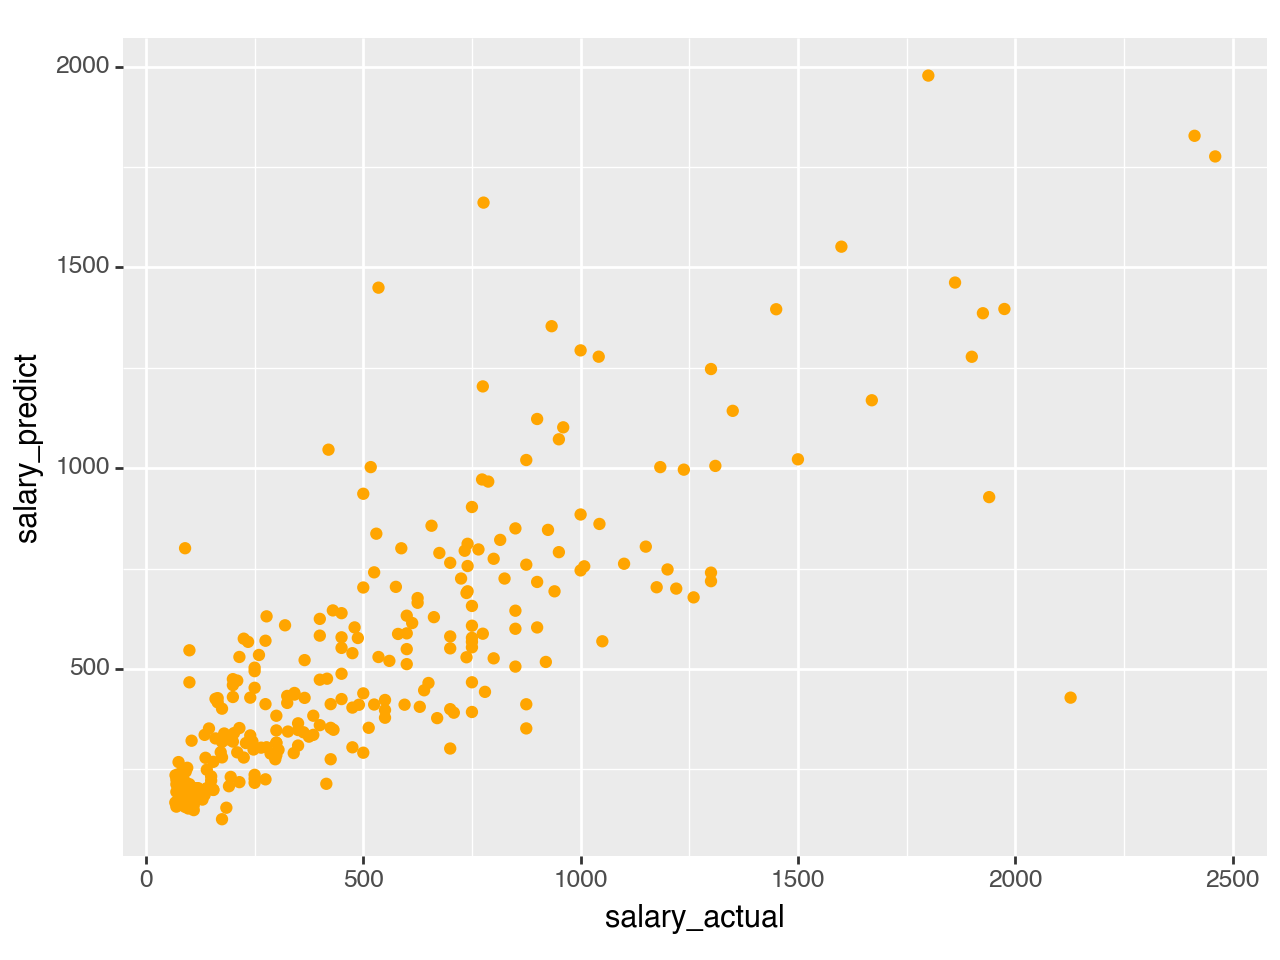

<Figure Size: (640 x 480)>

In [161]:
elastic_net_pipeline_tuned = Pipeline(
    [("dummified", ct_dummies),
     ('standardized', ct_sd),
     ('interaction', ct_inter),
     ("elastic_net_regression", ElasticNet(alpha=0.1, l1_ratio=0.0001))]
)

elastic_net_tuned_fitted = elastic_net_pipeline_tuned.fit(X_3, y_3)

elastic_net_tuned_fitted.predict(X_3)

graph_data = pd.DataFrame(data={
    'salary_actual':y_3,'salary_predict':elastic_net_tuned_fitted.predict(X_3)})


from plotnine import ggplot, aes, geom_point

p = (ggplot(graph_data, aes(x='salary_actual')) +
     geom_point(aes(y='salary_predict'), color='orange') )
p

My final best pipeline is a elastic_net with alpha=0.1, l1_ratio=0.0001. It has a mse of 91612, which is the smallest out of all my models. The graph I made compared the actual salry versus the salary that is predicted by this model. If the y=x for the data point, it indicates that it did a perfect prediction. In our case, our data points are all spread around y=x, meaning we relatively did a good job on predicting.